项目名称：新服生态研究

项目描述：服务器生态是影响玩家交互以及各类社交类玩法的重要因素，会对玩家的长线留存产生重要的影响，但是渠道导量并未过多考虑游戏设计，导入的新增量时大时小，没有规律。需要根据过往数据研究新服生态，查看不同渠道下，多少规模的导入量能够带来最大的收益，给渠道提供明确的导量建议

In [1]:
import jieba
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

import os
os.chdir('C:/Users/Administrator/Desktop/个人作品/辰光项目/新服生态/数据源/')

import datetime

import warnings
warnings.filterwarnings('ignore') 

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.sans-serif']=['SimHei'] 

1、数据清洗：从原始数据中，找出构建模型所需的数据

In [4]:
def server_filiter(df,start,end,days):
    df = df[(df['状态'] != '已删除') & (df['审核服'] != '是')]
    df['开服日期'] = pd.to_datetime(df['开服时间'].str.split(' ').str[0])
    
    result = df[(df['开服日期'] >= start)&(df['开服日期']<= end)]
    result['截止日期'] = result['开服日期'] + datetime.timedelta(days - 1)
    
    return result[['服务器ID','渠道名','开服日期','截止日期']]

#清洗数据：挑选出符合time_tabel的数据
def clean_data(data,time_col,server_col,time_tabel):
    
    data_range = pd.merge(data,time_tabel,left_on =server_col,right_on = '服务器ID',how = 'left')
    data_range[time_col] = pd.to_datetime(data_range[time_col].str.split(' ').str[0])
    data_range = data_range.drop_duplicates([time_col,'角色ID'])
    data_range = data_range[(data_range[time_col] >= data_range['开服日期']) & (data_range[time_col] <= data_range['截止日期'])]   

    return data_range


#计算金额总和：不去重
def clean_money(data,time_col,server_col,time_tabel):
    data_range = pd.merge(data,time_tabel,left_on =server_col,right_on = '服务器ID',how = 'left')
    data_range[time_col] = pd.to_datetime(data_range[time_col].str.split(' ').str[0])
    data_range = data_range[(data_range[time_col] >= data_range['开服日期']) & (data_range[time_col] <= data_range['截止日期'])]   

    return data_range

#根据开服日期，挑选出所需的服务器：
server_lst = pd.read_csv('游戏服查询.csv')
server_select = server_filiter(server_lst,'start','end',3)

#读取登录付费等数据
role_tabel = pd.read_csv('玩家角色管理.csv')
log = pd.read_csv('玩家登录日志_按天去重.csv')
order = pd.read_csv('充值流水.csv')

#清洗出所需的数据
new_clean = clean_data(role_tabel,'创建时间','服务器ID',server_select)
log_clean = clean_data(log,'日期','服务器ID',server_select)
money_clean = clean_data(order,'完成时间','服务器',server_select)

new_count = new_clean[['服务器ID','角色ID']].groupby(['服务器ID']).count().rename(columns = {'角色ID':'新增'})
log_count = log_clean[['服务器ID','角色ID']].groupby(['服务器ID']).count().rename(columns = {'角色ID':'登录'})
money_count = money_clean[['服务器','角色ID']].groupby(['服务器']).count().rename(columns = {'角色ID':'充值人数'})

#汇总 计算单服数据
money = clean_money(order,'完成时间','服务器',server_select)
money_sum = money[['服务器','充值金额']].groupby(['服务器']).sum().rename(columns = {'充值金额':'充值'})

basic_data = pd.concat([new_count,log_count,money_count,money_sum],axis = 1)
basic_data['付费率'] = basic_data['充值人数'] / basic_data['登录']
basic_data['ARPPU'] = basic_data['充值'] / basic_data['充值人数']
basic_data['ARPU'] = basic_data['充值'] / basic_data['登录']

basic_data = pd.merge(basic_data,server_select.set_index('服务器ID'),left_index = True,right_on = '服务器ID',how = 'left').reset_index()[['服务器ID',
             '渠道名','开服日期','截止日期','新增','登录','充值人数','充值','付费率','ARPPU','ARPU']]

2、完成数据清洗后，查看数据分布情况

In [5]:
basic_data.iloc[:,4:].describe()

,新增,登录,充值人数,充值,付费率,ARPPU,ARPU
count,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000
mean,6749.122581,8903.058065,296.851613,11623.651613,0.035434,39.792904,1.421946
std,3297.591113,4212.624149,164.467097,7078.641942,0.014156,10.857693,0.703291
min,72.000000,90.000000,3.000000,156.000000,0.011224,17.222930,0.276398
25%,5027.000000,6726.500000,191.000000,6727.000000,0.025387,33.329571,0.893356
50%,6485.000000,8789.000000,273.000000,10296.000000,0.033121,38.447514,1.321773
75%,8850.500000,11831.000000,400.000000,16043.000000,0.045666,44.874801,1.818836
max,19940.000000,25603.000000,752.000000,36910.000000,0.078603,81.317073,3.683978


3、构建k_means聚类模型，分组为3

In [6]:
# Visualizing clusters
def visualize_clusters(df, num_clusters):
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
    fig = plt.figure(figsize = (12,6))
    for n in range(num_clusters):
        clustered_df = df[df['cluster'] == n]
        plt.scatter(clustered_df['新增'], clustered_df['ARPU'], c=colors[n-1])
        plt.xlabel('新增', fontsize=13)
        plt.ylabel('ARPU', fontsize=13)
    plt.show()

In [7]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3)
kmeans.fit(basic_data[['ARPU', '新增']])
basic_data['cluster'] = kmeans.labels_

In [8]:
basic_data.to_csv('basic_data.csv',encoding = 'utf_8_sig')

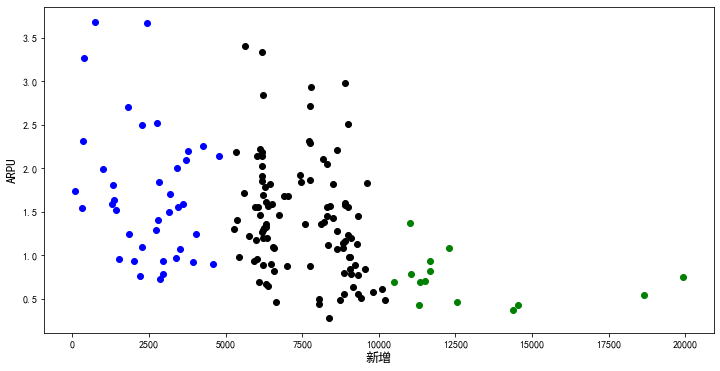

In [9]:
visualize_clusters(basic_data[['ARPU', '新增','cluster']],3)

可视化分类结果如上，模型基于新增和arpu将数据分为三种不同的类别，可以看出整体还是根据导量规模进行分类的

In [10]:
basic_data['channel_kind'] = basic_data['渠道名'].astype('category').cat.codes
basic_data['渠道名'] = basic_data['渠道名'].str[:2]
basic_data.groupby('cluster').mean().sort_values('新增').drop('服务器ID',axis = 1)

,新增,登录,充值人数,充值,付费率,ARPPU,ARPU,channel_kind
cluster,,,,,,,,
1,2494.384615,3397.897436,137.025641,5518.666667,0.041411,42.504638,1.705876,7.282051
0,7514.088235,10017.774510,354.352941,13984.568627,0.035211,39.386545,1.409911,6.872549
2,13028.285714,16117.357143,323.142857,11429.428571,0.020406,35.199406,0.718679,4.357143


上面求出各个分类下的数据平均值，分组结果中，小、中、大三个服的新增平均值分别为2000,7000与13000，其中中等规模的服务器付费数据最好，APPU与ARPU与小服差异不大，但充值金额是其2.5倍；大服用户量的增长并未带来较好的数据表现

下面对大中小三种不同规模服务器进行数据可视化，每个点代表一个服，以颜色区分渠道，有深浅之分

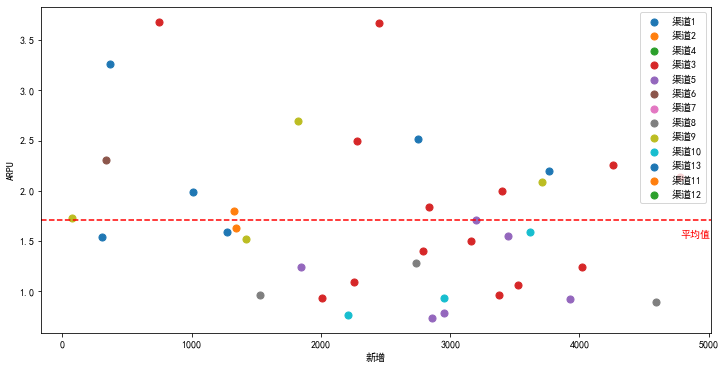

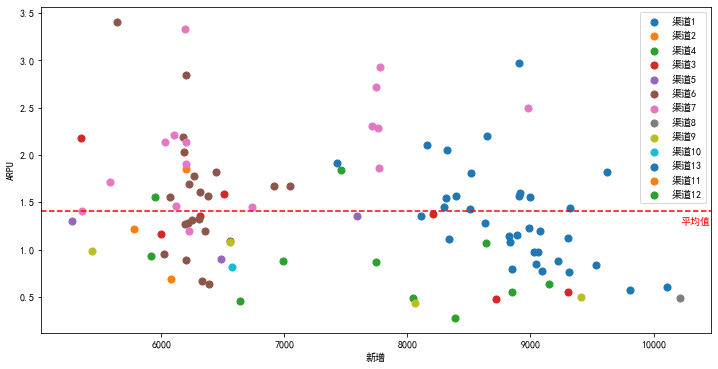

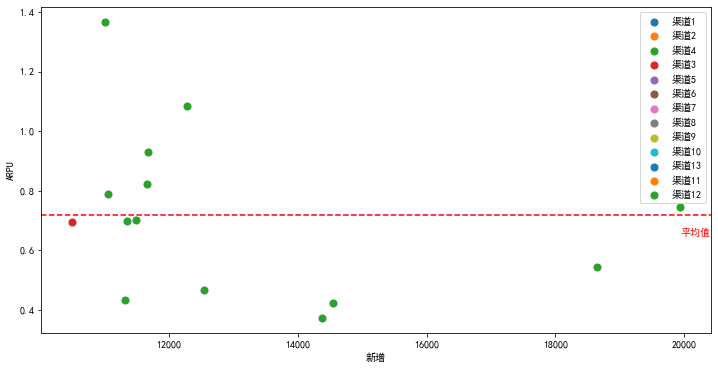

In [18]:
lst1 = []
lst2 = []
for n in [1,0,2]:
    fig = plt.figure(figsize = (12,6))
    for i in basic_data['渠道名2'].unique():
        df = basic_data[(basic_data['cluster'] == n)&(basic_data['渠道名2'] == i)]
        plt.scatter(df['新增'],df['ARPU'],alpha = 1,label = i,s = 50)
        plt.legend(loc = 'upper right')
        plt.xlabel('新增')
        plt.ylabel('ARPU') 
        
    cluster = basic_data[basic_data['cluster'] == n]
    plt.axhline(cluster['ARPU'].mean(),c = 'r',linestyle = '--',alpha = 1)
    plt.text(cluster['新增'].max(),cluster['ARPU'].mean() -cluster['ARPU'].mean()*0.1,'平均值',fontsize=10,color = 'red')
    plt.show()
    lst1.append((cluster['ARPU'] >= cluster['ARPU'].mean()).sum())
    lst2.append(len(cluster))

对于小服而言，导量建议为：2200-3700左右

对于中服而言，导量建议为：5000-7700左右，此外目前只有一家在8000-10000的量级能够保证arpu，并不建议其他渠道模仿

对于大服而言，导量建议为：10000-12000左右，大服的数据表现整体不好，不建议大量导入